In [2]:
# Core
import pandas as pd
import numpy as npa

# ML & Metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# MLflow
import mlflow
import mlflow.sklearn


In [3]:
# Load the preprocessed dataset
df = pd.read_csv("../data/diabetes.csv")

# Define features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [4]:
from itertools import product

# Define hyperparameter values to try
C_values = [0.1, 1.0, 10.0]
solvers = ['liblinear', 'lbfgs']

# Loop over all combinations
for C, solver in product(C_values, solvers):
    with mlflow.start_run():
        model = LogisticRegression(C=C, solver=solver, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Log parameters and metrics
        mlflow.log_param("C", C)
        mlflow.log_param("solver", solver)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)

        # Log the model
        mlflow.sklearn.log_model(model, "model")

        print(f"✔️ Run logged with C={C}, solver={solver}")


2025/04/23 00:27:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Run logged with C=0.1, solver=liblinear


2025/04/23 00:28:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Run logged with C=0.1, solver=lbfgs


2025/04/23 00:28:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Run logged with C=1.0, solver=liblinear


2025/04/23 00:28:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Run logged with C=1.0, solver=lbfgs


2025/04/23 00:28:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Run logged with C=10.0, solver=liblinear


2025/04/23 00:28:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✔️ Run logged with C=10.0, solver=lbfgs


In [5]:
# Define the list of hyperparameter values to test
c_values = [0.01, 0.1, 1.0, 10.0]

# Track results
best_score = 0
best_c = None

for c in c_values:
    with mlflow.start_run(run_name=f"logreg_C={c}"):
        # Train model with given C
        model = LogisticRegression(C=c, solver='liblinear', max_iter=1000)
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

        # Log params and metrics
        mlflow.log_param("C", c)
        mlflow.log_metric("cv_accuracy", score)

        if score > best_score:
            best_score = score
            best_c = c

print(f"✅ Best model: C={best_c} with accuracy={best_score:.4f}")


✅ Best model: C=10.0 with accuracy=0.7655


In [6]:
# Define search space
search_space = {
    'C': hp.uniform('C', 0.01, 10)
}

# Define objective function
def objective(params):
    with mlflow.start_run(nested=True):
        model = LogisticRegression(C=params['C'], solver='liblinear', max_iter=1000)
        score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()

        # Log params and metrics to MLflow
        mlflow.log_param("C", params['C'])
        mlflow.log_metric("cv_accuracy", score)

        return {'loss': -score, 'status': STATUS_OK}

# Run Hyperopt optimization
trials = Trials()
best = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=20, trials=trials)

print("✅ Best hyperparameter from Hyperopt:", best)


100%|██████████| 20/20 [00:03<00:00,  6.45trial/s, best loss: -0.7687591630014661]
✅ Best hyperparameter from Hyperopt: {'C': 2.898579150992969}


In [7]:
# Extract results from Hyperopt trials
results = []
for i, trial in enumerate(trials.trials):
    result = {
        "Trial": i + 1,
        "C": trial["result"]["params"]["C"] if "params" in trial["result"] else trial["misc"]["vals"]["C"][0],
        "CV Accuracy": -trial["result"]["loss"]
    }
    results.append(result)

df_trials = pd.DataFrame(results)

# Highlight best result
best_idx = df_trials["CV Accuracy"].idxmax()
df_trials.loc[best_idx, "Best"] = "✅"


In [8]:
df_trials

,Trial,C,CV Accuracy,Best
0,1,6.292674,0.765507,NaN
1,2,8.797223,0.765520,NaN
2,3,8.414526,0.767146,NaN
3,4,5.576181,0.767133,NaN
4,5,0.118889,0.708570,NaN
5,6,6.533412,0.765507,NaN
6,7,7.440467,0.767146,NaN
7,8,4.432211,0.768746,NaN
8,9,4.019055,0.768746,NaN
9,10,2.898579,0.768759,✅


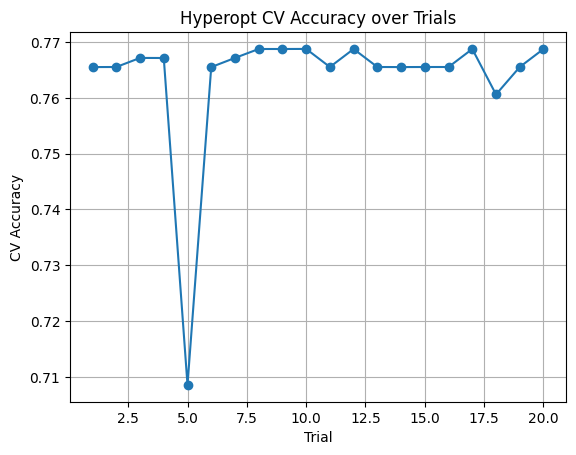

In [9]:
import matplotlib.pyplot as plt

plt.plot(df_trials["Trial"], df_trials["CV Accuracy"], marker='o')
plt.title("Hyperopt CV Accuracy over Trials")
plt.xlabel("Trial")
plt.ylabel("CV Accuracy")
plt.grid(True)
plt.show()

In [10]:
print("Best parameter found by Hyperopt:")
print(f"C = {best['C']:.4f}")

Best parameter found by Hyperopt:
C = 2.8986
